In [2]:
import wandb
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
api = wandb.Api()
entity = "evangeorgerex"
project = "fwal"

results_dir = r'/home/er647/projects/feature-wise-active-learning/results'

# Utilities

In [3]:

def get_mnar_data(run):
    '''
    returns:
        float: optimal test-time intervention validation f1
        float: optimal test-time intervention test f1
        float: full test-time intervention validation f1
        float: full test-time intervention test f1
    '''

    history_dict = {}
    
    # Iterate through the run history to extract the desired metrics
    keys = [
        "fraction_missing_features",
        "mean_MNAR_imputation_test_metrics.F1_weighted", "missforest_MNAR_imputation_test_metrics.F1_weighted", 'ice_MNAR_imputation_test_metrics.F1_weighted'
        ]
    
    for row in run.scan_history():
        # print('.')
        # Check if both keys exist in the current row
        for key in keys:
            if key in row and row[key] is not None:
                if key not in history_dict:
                    history_dict[key] = []
                history_dict[key].append(row[key])
            # else:
            #     # print(key)
            #     continue
    history_dict['fraction_missing_features'] = np.unique(history_dict['fraction_missing_features'])

    return history_dict

def get_mcar_data(run):
    '''
    returns:
        float: optimal test-time intervention validation f1
        float: optimal test-time intervention test f1
        float: full test-time intervention validation f1
        float: full test-time intervention test f1
    '''

    history_dict = {}
    
    
            # 'fraction_missing_features_MCAR'+logging_key: fraction,
            # 'MCAR_imputation_valid_metrics'+logging_key: valid_metrics,
            # 'MCAR_imputation_test_metrics'+logging_key: test_metrics

    # Iterate through the run history to extract the desired metrics
    
    keys = [
        "fraction_missing_features",
        "mean_MCAR_imputation_test_metrics.F1_weighted", "missforest_MCAR_imputation_test_metrics.F1_weighted", 'ice_MCAR_imputation_test_metrics.F1_weighted'
        ]
    
    for row in run.scan_history():
        # print('.')
        # Check if both keys exist in the current row
        for key in keys:
            if key in row and row[key] is not None:
                if key not in history_dict:
                    history_dict[key] = []
                history_dict[key].append(row[key])
            # else:
            #     # print(key)
            #     continue
    history_dict['fraction_missing_features'] = np.unique(history_dict['fraction_missing_features'])
    return history_dict

def plot_mcar(mcar_data):
    '''
    Plots the test-time intervention F1 scores for MCAR and MNAR missing data
    '''
    # Create a pandas dataframe from the data
    mcar_df = pd.DataFrame(mcar_data)

    # Plot the data
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=mcar_df, x="fraction_missing_features", y="mean_MCAR_imputation_test_metrics.F1_weighted", label="MCAR")
    plt.xlabel("Fraction of missing features")
    plt.ylabel("F1 score")
    plt.title("F1 score for MCAR and MNAR missing data")
    plt.legend()
    plt.show()


In [4]:

def get_run_data(run):
    """
    Extracts both MCAR and MNAR data for a given run.
    """
    mcar_data = get_mcar_data(run)
    mnar_data = get_mnar_data(run)
    return mcar_data, mnar_data

def get_sweep_runs(api, entity, project, sweep_id):
    """
    Retrieves and processes all runs within a given sweep.
    """
    sweep_runs = api.sweep(f"{entity}/{project}/{sweep_id}").runs
    all_run_data = {}
    for run in sweep_runs:
        if run.state != "finished":
            continue
        run_id = run.id
        mcar_data, mnar_data = get_run_data(run)
        all_run_data[run_id] = {
            'mcar': mcar_data,
            'mnar': mnar_data,
            'dataset': run.config['dataset']  # assuming dataset info is stored in run configuration
        }
    return all_run_data

def aggregate_data_by_dataset(all_run_data):
    """
    Aggregates run data by dataset.
    """
    dataset_data = {}
    for run_id, data in all_run_data.items():
        dataset_name = data['dataset']
        if dataset_name not in dataset_data:
            dataset_data[dataset_name] = {'mcar': [], 'mnar': []}
        dataset_data[dataset_name]['mcar'].append(data['mcar'])
        dataset_data[dataset_name]['mnar'].append(data['mnar'])
    return dataset_data

def plot_dataset_mnar(dataset_data, dataset_name):
    """
    Plots MNAR data for a specific dataset.
    """
    data = pd.concat([pd.DataFrame(d) for d in dataset_data[dataset_name]['mnar']])
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x="fraction_missing_features", y="mean_MNAR_imputation_test_metrics.F1_weighted", label="Mean MNAR")
    sns.lineplot(data=data, x="fraction_missing_features", y="missforest_MNAR_imputation_test_metrics.F1_weighted", label="MissForest MNAR")
    sns.lineplot(data=data, x="fraction_missing_features", y="ice_MNAR_imputation_test_metrics.F1_weighted", label="ICE MNAR")
    plt.xlabel("Fraction of Missing Features")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Scores for MNAR Missing Data in Dataset: {dataset_name}")
    plt.legend()
    plt.show()

def plot_dataset_mcar(dataset_data, dataset_name):
    """
    Plots McAR data for a specific dataset.
    """
    data = pd.concat([pd.DataFrame(d) for d in dataset_data[dataset_name]['mcar']])
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x="fraction_missing_features", y="mean_MCAR_imputation_test_metrics.F1_weighted", label="Mean MCAR")
    sns.lineplot(data=data, x="fraction_missing_features", y="missforest_MCAR_imputation_test_metrics.F1_weighted", label="MissForest MCAR")
    sns.lineplot(data=data, x="fraction_missing_features", y="ice_MCAR_imputation_test_metrics.F1_weighted", label="ICE MCAR")
    plt.xlabel("Fraction of Missing Features")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Scores for MNAR Missing Data in Dataset: {dataset_name}")
    plt.legend()
    plt.show()


In [5]:

# Define line styles and colors
line_styles = {
    "mean": '-',        # solid line for mean
    "missforest": '--', # dashed line for MissForest
    "ice": ':',         # dotted line for ICE
}
# Using a more subdued color palette
colors = {
    "MLP": "#377eb8",    # blue
    "xgboost": "#4daf4a", # green
    "F-Act": "#ff7f00", # orange
    "lasso": "#984ea3", # purple
    # Add more models/colors as necessary
}

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def get_mnar_data(run):
    '''
    returns:
        float: optimal test-time intervention validation f1
        float: optimal test-time intervention test f1
        float: full test-time intervention validation f1
        float: full test-time intervention test f1
    '''

    history_dict = {}
    
    # Iterate through the run history to extract the desired metrics
    keys = [
        "fraction_missing_features",
        "mean_MNAR_imputation_test_metrics.F1_weighted", "missforest_MNAR_imputation_test_metrics.F1_weighted", 'ice_MNAR_imputation_test_metrics.F1_weighted'
        ]
    
    for row in run.scan_history():
        # print('.')
        # Check if both keys exist in the current row
        for key in keys:
            if key in row and row[key] is not None:
                if key not in history_dict:
                    history_dict[key] = []
                history_dict[key].append(row[key])
            # else:
            #     # print(key)
            #     continue
    history_dict['fraction_missing_features'] = np.unique(history_dict['fraction_missing_features'])

    return history_dict

def get_mcar_data(run):
    '''
    returns:
        float: optimal test-time intervention validation f1
        float: optimal test-time intervention test f1
        float: full test-time intervention validation f1
        float: full test-time intervention test f1
    '''

    history_dict = {}
    
    
            # 'fraction_missing_features_MCAR'+logging_key: fraction,
            # 'MCAR_imputation_valid_metrics'+logging_key: valid_metrics,
            # 'MCAR_imputation_test_metrics'+logging_key: test_metrics

    # Iterate through the run history to extract the desired metrics
    
    keys = [
        "fraction_missing_features",
        "mean_MCAR_imputation_test_metrics.F1_weighted", "missforest_MCAR_imputation_test_metrics.F1_weighted", 'ice_MCAR_imputation_test_metrics.F1_weighted'
        ]
    
    for row in run.scan_history():
        # print('.')
        # Check if both keys exist in the current row
        for key in keys:
            if key in row and row[key] is not None:
                if key not in history_dict:
                    history_dict[key] = []
                history_dict[key].append(row[key])
            # else:
            #     # print(key)
            #     continue
    history_dict['fraction_missing_features'] = np.unique(history_dict['fraction_missing_features'])
    return history_dict


def get_run_data(run):
    """
    Extracts both MCAR and MNAR data for a given run.
    """
    mcar_data = get_mcar_data(run)
    mnar_data = get_mnar_data(run)
    return mcar_data, mnar_data

def get_all_sweeps(api, entity, project, sweep_ids):
    """
    Retrieves and processes all runs across multiple sweeps.
    """
    all_run_data = {}
    for sweep_id in sweep_ids:
        sweep_runs = api.sweep(f"{entity}/{project}/{sweep_id}").runs
        for run in sweep_runs:
            if run.state != "finished":
                continue
            run_id = run.id
            mcar_data, mnar_data = get_run_data(run)
            model = run.config['model']  # extracting model name from the run configuration
            dataset = run.config['dataset']
            all_run_data[run_id] = {
                'mcar': mcar_data,
                'mnar': mnar_data,
                'model': model,
                'dataset': dataset
            }
    return all_run_data

def aggregate_data_by_dataset_and_model(all_run_data):
    """
    Aggregates run data by dataset and model.
    """
    aggregated_data = {}
    for run_id, data in all_run_data.items():
        dataset_name = data['dataset']
        model_name = data['model']
        if model_name == 'fwal':
            model_name = 'MLP'
        key = (dataset_name, model_name)
        if key not in aggregated_data:
            aggregated_data[key] = {'mcar': [], 'mnar': []}
        aggregated_data[key]['mcar'].append(data['mcar'])
        aggregated_data[key]['mnar'].append(data['mnar'])
    return aggregated_data

def aggregated_data_to_df(aggregated_data):
    data = aggregated_data
    columns = ['dataset', 'method', 'model', 'imputation', 'base_model', 'F1', 'missing_perc']
    df_rows = []

    # Process each dataset and method/model combination
    for (dataset, model), methods in data.items():
        for method, entries in methods.items():
            for entry in entries:
                missing_percs = entry['fraction_missing_features']
                for model_key, f1_scores in entry.items():
                    if model_key == 'fraction_missing_features':
                        continue
                    # Extract the model name and cleanup
                    imputation = model_key.split('_')[0]  # Adjust based on actual key names
                    model_name = imputation + ' ' + model
                    for f1, missing_perc in zip(f1_scores, missing_percs):
                        df_rows.append([dataset, method, model_name, imputation, model, f1, missing_perc])

    # Create DataFrame
    df = pd.DataFrame(df_rows, columns=columns)
    df['missing_perc'] = df['missing_perc'].astype(float) * 100
    return df

def plot_mcar_by_dataset(aggregated_data, dataset_name):
    """
    Plots MCAR data for all models for a specified dataset with aesthetic customizations.
    """
    plt.figure(figsize=(12, 8))
    for (dataset, model_name), data in aggregated_data.items():
        if dataset == dataset_name and data['mcar']:
            df = pd.concat([pd.DataFrame(d) for d in data['mcar'] if d])
            if not df.empty:
                for method in ['mean', 'missforest', 'ice']:
                    column_name = f"{method}_MCAR_imputation_test_metrics.F1_weighted"
                    if column_name in df.columns:
                        sns.lineplot(
                            data=df, x="fraction_missing_features", y=column_name,
                            label=f"{method.capitalize()} {model_name} MCAR",
                            linestyle=line_styles[method], color=colors.get(model_name, "#e41a1c") # default color if model not listed
                        )
    
    plt.xlabel("Fraction of Missing Features")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Scores for MCAR Missing Data in Dataset: {dataset_name}")
    plt.legend()
    plt.show()

def plot_mnar_by_dataset(aggregated_data, dataset_name):
    """
    Plots MNAR data for all models for a specified dataset with aesthetic customizations.
    """
    plt.figure(figsize=(12, 8))
    for (dataset, model_name), data in aggregated_data.items():
        if dataset == dataset_name and data['mnar']:
            df = pd.concat([pd.DataFrame(d) for d in data['mnar'] if d])
            if not df.empty:
                for method in ['mean', 'missforest', 'ice']:
                    column_name = f"{method}_MNAR_imputation_test_metrics.F1_weighted"
                    if column_name in df.columns:
                        sns.lineplot(
                            data=df, x="fraction_missing_features", y=column_name,
                            label=f"{method.capitalize()} {model_name} MNAR",
                            linestyle=line_styles[method], color=colors.get(model_name, "#e41a1c") # default color if model not listed
                        )
    
    plt.xlabel("Fraction of Missing Features")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Scores for MNAR Missing Data in Dataset: {dataset_name}")
    plt.legend()
    plt.show()


# Load baselines

## From wandb

In [7]:

sweep_ids = [
    '7mg4b4vk', # XGB
    'wxtztkxy', # MLP
    'agf9pb9t',  # LASSO
    '5jj6p7p2', # SEFS
    'a53eo18d', # RF
    '9ttafcmg', # cae
    'ges23c7b', # supervised cae
    
    # PBMC:
    'j02men3l', # cae
    'wnqwmpr2', # lasso
    '23utoryh', # mlp
    'wocijeqx', # rf
    '7v0xkqxj', # sefs
    'lzxyjtld', # supervised cae
    'wougel6g', # xgb
    
    # finance:
    'n58j3sqb', # cae
    'xprjnu4r', # lasso
    'ayygv27o', # mlp
    'btv109nn', # rf
    '6ykxmxqn', # sefs
    '69b6ovbr', # supervised cae
    'k7jqc1q8', # xgb
    
    # COIL20:
    '0e94xqes', # lasso
    'oqtm21r6', # mlp
    'zcm4lu47', # rf
    'wmg1bb7b', # sefs
    'vtvt1ccr', # xgb
    ]  # Add your sweep IDs
all_run_data = get_all_sweeps(api, entity, project, sweep_ids)
aggregated_data = aggregate_data_by_dataset_and_model(all_run_data)


In [8]:

def get_mnar_data_fact(run):
    '''
    returns:
        float: optimal test-time intervention validation f1
        float: optimal test-time intervention test f1
        float: full test-time intervention validation f1
        float: full test-time intervention test f1
    '''

    history_dict = {}
    
    
            # 'fraction_missing_features_MCAR'+logging_key: fraction,
            # 'MCAR_imputation_valid_metrics'+logging_key: valid_metrics,
            # 'MCAR_imputation_test_metrics'+logging_key: test_metrics

    # Iterate through the run history to extract the desired metrics
    keys = [
        "fraction_missing_features_MNAR",
        "feature_selection_valid_metrics.F1_weighted", "feature_selection_test_metrics.F1_weighted", 
        ]
    for row in run.scan_history():
        # print('.')
        # Check if both keys exist in the current row
        for key in keys:
            if key in row and row[key] is not None:
                if key not in history_dict:
                    history_dict[key] = []
                history_dict[key].append(row[key])
            # else:
            #     # print(key)
            #     continue
    return history_dict

def get_mcar_data_fact(run):
    '''
    returns:
        float: optimal test-time intervention validation f1
        float: optimal test-time intervention test f1
        float: full test-time intervention validation f1
        float: full test-time intervention test f1
    '''

    history_dict = {}
    
    
            # 'fraction_missing_features_MCAR'+logging_key: fraction,
            # 'MCAR_imputation_valid_metrics'+logging_key: valid_metrics,
            # 'MCAR_imputation_test_metrics'+logging_key: test_metrics

    # Iterate through the run history to extract the desired metrics
    keys = [
        "fraction_missing_features_MCAR",
        "MCAR_imputation_valid_metrics.F1_weighted", "MCAR_imputation_test_metrics.F1_weighted", 
        ]
    for row in run.scan_history():
        # print('.')
        # Check if both keys exist in the current row
        for key in keys:
            if key in row and row[key] is not None:
                if key not in history_dict:
                    history_dict[key] = []
                history_dict[key].append(row[key])
            # else:
            #     # print(key)
            #     continue
    return history_dict


def get_sweep_runs_fact(api, entity, project, sweep_ids):
    """
    Retrieves and processes all runs within a given sweep.
    """
    all_run_data = {}
    
    for sweep_id in sweep_ids:
        if isinstance(sweep_id, list):
            run_ids = sweep_id
            for run_id in run_ids:
                run = api.run(f"{entity}/{project}/{run_id}")
                mcar_data = get_mcar_data_fact(run) 
                mnar_data = get_mnar_data_fact(run)
                all_run_data[run_id] = {
                    'mcar': mcar_data,
                    'mnar': mnar_data,
                    'dataset': run.config['dataset']  # assuming dataset info is stored in run configuration
                }
        else:
            sweep_runs = api.sweep(f"{entity}/{project}/{sweep_id}").runs
            for run in sweep_runs:
                run_id = run.id
                mcar_data = get_mcar_data_fact(run) 
                mnar_data = get_mnar_data_fact(run)
                all_run_data[run_id] = {
                    'mcar': mcar_data,
                    'mnar': mnar_data,
                    'dataset': run.config['dataset']  # assuming dataset info is stored in run configuration
                }
    return all_run_data

def extract_data(nested_dict):
    data = []

    for key, datasets in nested_dict.items():
        dataset_name = datasets.get('dataset')
        for method, details in datasets.items():
            if method in ['mcar', 'mnar']:
                # Extract the specific method's metrics
                # f1_key = [k for k in details.keys() if 'metrics.F1' in k and 'valid' in k][0]
                f1_key = [k for k in details.keys() if 'metrics.F1' in k and 'test' in k][0]
                missing_perc = details['fraction_missing_features_' + method.upper()]
                f1_scores = details[f1_key]

                for perc, f1 in zip(missing_perc, f1_scores):
                    data.append({
                        'dataset': dataset_name,
                        'method': method,
                        'model': 'F-Act',
                        'imputation': '',
                        'base_model': 'F-Act',
                        'F1': f1,
                        'missing_perc': float(perc) * 100
                    })

    return pd.DataFrame(data)




In [10]:
baselines_df = aggregated_data_to_df(aggregated_data)


In [11]:
# save baselines_df to csv
baselines_df.to_csv(results_dir + '/baselines_df.csv', index=False)

## From csv

In [4]:
# load baselines_df from csv
baselines_df = pd.read_csv(results_dir + '/baselines_df.csv')

# Fact

## Fact utilities

## Load from wandb

In [9]:
fact_sweep_ids = [
    '8a09w5x3', # 3x isolet, coil20, poly ; 1 x usps,finance 
    'd9jds50i', # completed failed 2x finance, USPS
    'lqlpi6z0', # madelon 
    'v3q2j39f', # mice protein 
    # # 'bx9ez4ps', # PBMC
    ['epq7q7g4', 'mdqpm0qb', 'unn4pzqd'], # PBMC better
]
fact_data = get_sweep_runs_fact(api, entity, project, fact_sweep_ids)

In [12]:
fact_df = extract_data(fact_data)

In [18]:
# save to csv
fact_df.to_csv(results_dir + '/fact_df.csv', index=False)

## Load from csv

In [5]:
# load from csv
fact_df = pd.read_csv(results_dir + '/fact_df.csv')

# Plotting

## Plot averaged across datasets

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_avg_across_datasets(baselines_df, fact_df, method, save=False):
    # Create a 2x2 subplot layout
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjust the figure size as needed

    # Font size settings
    axis_title_font_size = 24
    axis_label_font_size = 24
    legend_title_font_size = 24
    legend_font_size = 14

    # List to store handles and labels for the legend
    handles, labels = [], []
    
    titles = {
        'mean': 'Mean Imputation',
        'missforest': 'MissForest Imputation',
        'ice': 'ICE Imputation'
    }
    
    labels_dict = {
        'xgboost': 'XGBoost',
        'rf' : 'Random Forest',
        'lasso': 'Lasso',
        'F-Act': 'F-Act (Ours) (no auxiliary imputation)'
    }

    # Include MLP data
    mlp_df = baselines_df[baselines_df['base_model'] == 'MLP']

    # Iterate over imputations and plot each on its own axis
    for i, imputation in enumerate(['mean', 'missforest', 'ice']):
        # Select the right subplot for each imputation
        ax = axes.flatten()[i]

        # Filter the dataframe for the current imputation
        pre_df = baselines_df[(baselines_df['method'] == method) & (baselines_df['imputation'] == imputation)]
        pre_fact_df = fact_df[(fact_df['method'] == method)]

        # Concatenate current imputation data with MLP data
        df = pd.concat([pre_df, pre_fact_df, mlp_df])

        # Additional filtering
        df = df[df['dataset'] != 'poly_binarised_decimalised_synth']
        df = df[df['missing_perc'] <= 98]

        # Determine the unique base models and assign colors
        base_models = df['base_model'].unique()
        color_palette = sns.color_palette("tab10", n_colors=len(base_models))
        base_model_color = {base_model: color for base_model, color in zip(base_models, color_palette)}
        base_model_color['F-Act'] = 'black'  # Keep the F-Act model line black

        plot = sns.lineplot(ax=ax, data=df, x='missing_perc', y='F1', hue='base_model', marker='o', palette=base_model_color, estimator='mean', errorbar=('se',0.8))
        plot.set_title(titles[imputation], fontsize=axis_title_font_size)
        
                
        # Adjust labels according to specific plots
        if i == 0:
            ax.set_xlabel('')  # Remove x-axis label for the 1st plot
        else:
            ax.set_xlabel('% of missing features', fontsize=axis_label_font_size)

        if i == 1:
            ax.set_ylabel('')  # Remove y-axis label for the 2nd plot
        else:
            ax.set_ylabel('F1 Score', fontsize=axis_label_font_size)

        ax.tick_params(axis='both', which='major', labelsize=axis_label_font_size)

        # Get the handles and labels for the legend from the first loop
        if i == 0:
            handles, labels = ax.get_legend_handles_labels()
            # Find the index of 'F-Act' and move it to the end
            f_act_index = labels.index('F-Act')
            f_act_handle = handles.pop(f_act_index)
            f_act_label = labels.pop(f_act_index)
            handles.append(f_act_handle)
            labels.append(f_act_label)
            # Update the label for "F-Act" and "MLP" in the legend
            labels = [label if label not in labels_dict else labels_dict[label] for label in labels]
            # labels = [label if label != 'F-Act' else 'F-Act (Ours) (no auxiliary imputation)' for label in labels]
            if method == 'mnar':
                labels = [label if label != 'MLP' else 'MLP (no recommendations)' for label in labels]

    # Remove legends from individual plots
    for ax in axes.flatten()[:-1]:
        ax.get_legend().remove()

    # Plot the legend in the last subplot (bottom right)
    legend = axes.flatten()[-1].legend(handles, labels, loc='center', fontsize=legend_font_size, title="Model")
    plt.setp(legend.get_title(), fontsize=legend_title_font_size)  # Set font size for the legend title

    axes.flatten()[-1].axis('off')  # Hide the axis of the last subplot

    plt.tight_layout()
    
    if save:
        plt.savefig(results_dir + f'/dataset_avg_f1_vs_missing_features_{method}.pdf')
        
    plt.show()


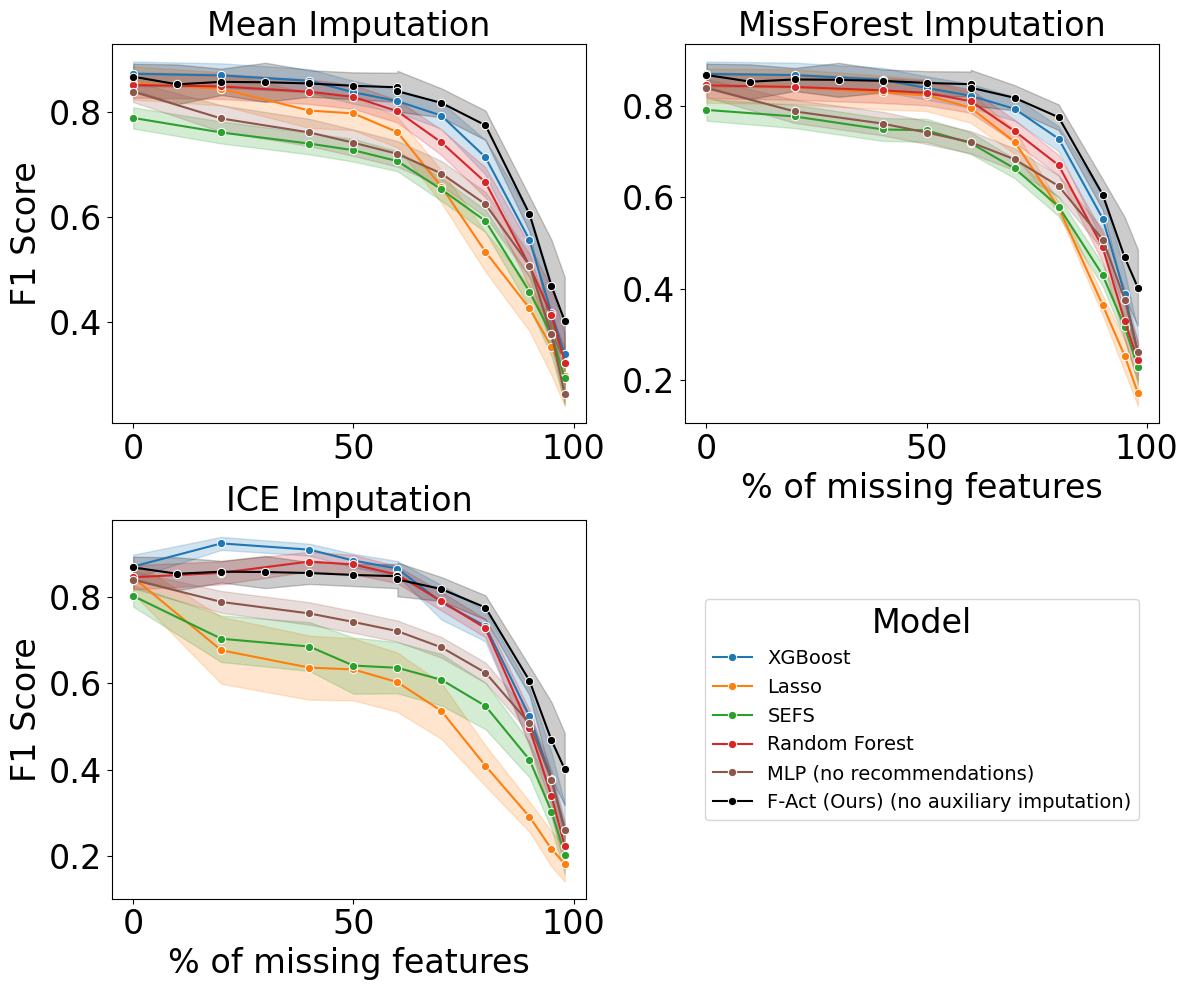

In [7]:
plot_avg_across_datasets(baselines_df, fact_df, 'mnar', save=True)


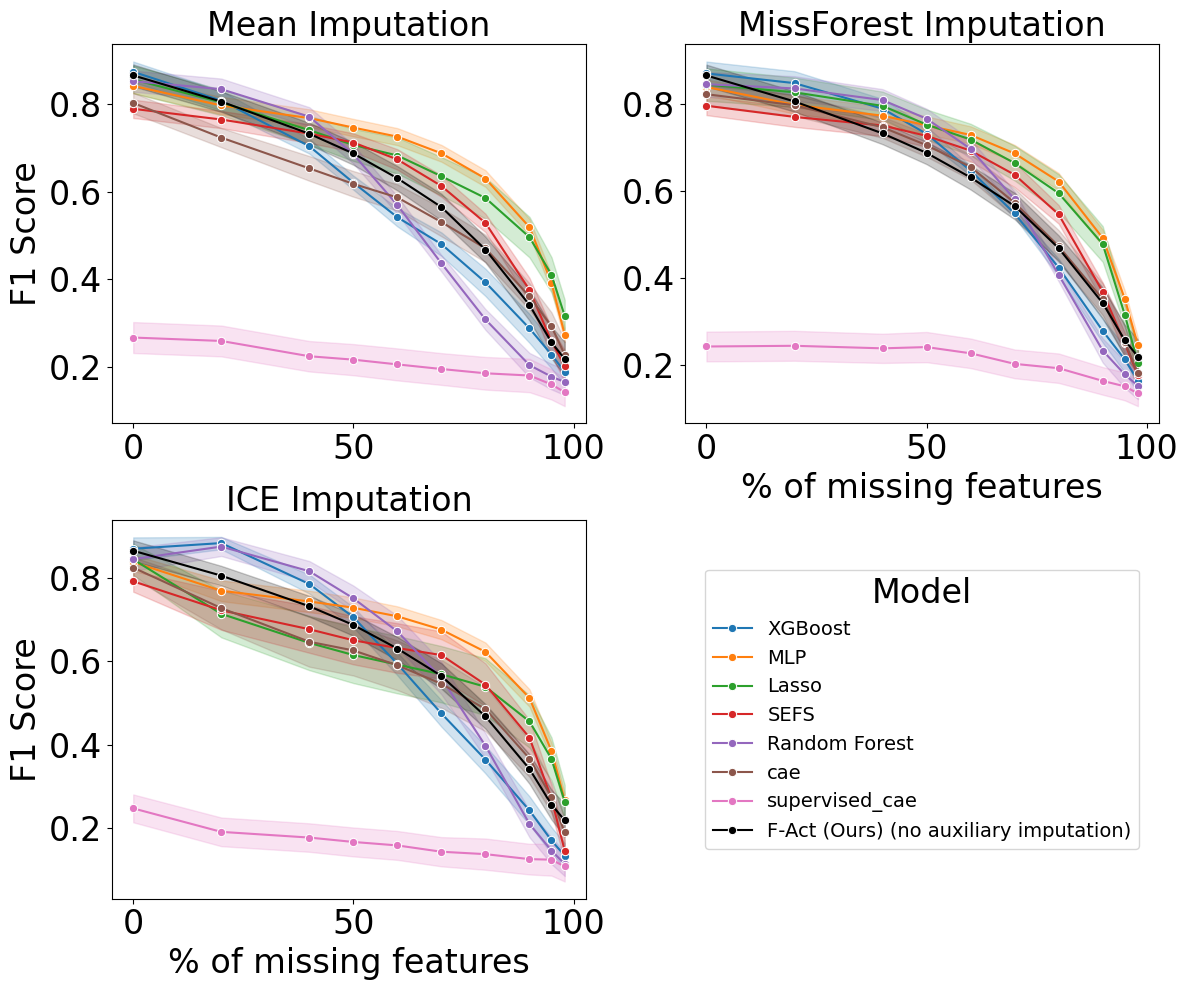

In [8]:
plot_avg_across_datasets(baselines_df, fact_df, 'mcar',save=True)


## Plot utilities

In [19]:
df = pd.concat([baselines_df, fact_df])
df = df[df['dataset'] != 'poly_binarised_decimalised_synth']
df = df[~((df['dataset'] == 'USPS') & (df['missing_perc'] > df[(df['dataset'] == 'USPS') & (df['model'] =='F-Act')]['missing_perc'].max()))]

In [20]:
def plot_f1_vs_missing_features(df, dataset_name, method, ax, base_model_color, line_styles):
    """
    Plots F1 score against the fraction of missing features from a DataFrame,
    without creating a legend in each subplot. Specific line styles based on the model type are used.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    - dataset_name (str): Name of the dataset to filter on.
    - method (str): Method to filter on.
    - ax (matplotlib.axes._subplots.AxesSubplot): Axes object to draw the plot on.
    - base_model_color (dict): Dictionary mapping base models to colors.
    - line_styles (dict): Dictionary mapping models to line styles.
    """
    # Filter the DataFrame based on the dataset name and method
    filtered_df = df[(df['dataset'] == dataset_name) & (df['method'] == method)]
    
    # Plot on the given axes object
    unique_models = filtered_df['model'].unique()
    for model in unique_models:
        subset = filtered_df[filtered_df['model'] == model]
        # Use base_model field to determine color
        base_model = subset['base_model'].iloc[0]  # Assuming each model has a consistent base_model
        label_name = 'F-Act (Ours)' if model == 'F-Act' else model
        sns.lineplot(data=subset, x='missing_perc', y='F1', label=label_name,
                     linestyle=line_styles.get(model, 'solid'), color=base_model_color[base_model], marker='o', ax=ax)
    
    # Set subplot title and labels
    title_map = {
        'USPS': 'USPS', 
        'mice_protein': 'Mice Protein', 
        'Isolet': 'Isolet', 
        'madelon': 'Madelon', 
        'COIL20': 'COIL20', 
        'PBMC': 'PBMC',
        'finance': 'Finance'
    }
    ax.set_title(title_map[dataset_name])
    ax.set_xlabel('Missing Features (%)')
    ax.set_ylabel('F1 Score')
    ax.grid(True)

    # Explicitly disable the legend for this subplot
    ax.legend_.remove()

def plot_f1_vs_missing_features_all_datasets(df, method, save = False):
    """
    Creates a grid of subplots for each dataset, plotting F1 scores against the fraction of missing features.
    A centralized legend is used for all subplots.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    - method (str): Method to filter on.
    """
    # Extract unique base models and assign unique colors
    base_models = df['base_model'].unique()
    color_palette = sns.color_palette("tab10", n_colors=len(base_models))
    base_model_color = {base_model: color for base_model, color in zip(base_models, color_palette)}

    base_model_color['F-Act'] = 'black'
    
    line_styles = {model: ('dashed' if 'missforest' in model.lower() else 'dotted' if 'ice' in model.lower() else 'solid') for model in df['model'].unique()}

    
    # dataset_names = ['USPS', 'mice_protein', 'Isolet', 'madelon' 'COIL20', 'PBMC', 'finance']
    dataset_names = ['USPS', 'mice_protein', 'Isolet', 'madelon', 'COIL20', 'PBMC','finance']
    
    # dataset_names = df['dataset'].unique()


    n_datasets = len(dataset_names)
    n_cols = 4  # You can adjust the number of columns
    n_rows = (n_datasets + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, dataset in enumerate(dataset_names):
        plot_f1_vs_missing_features(df, dataset, method, axes[i], base_model_color, line_styles)
        axes[i].legend().remove()  # remove individual legends

    # Hide unused axes if any
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Collect handles and labels for a centralized legend using the first plotted axis
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.88, 0.45), ncol=2, title="Model")
    
    fig.tight_layout()
    if save:
        plt.savefig(results_dir + f'/f1_vs_missing_features_{method}.png', dpi=300)
    plt.show()


## Plots

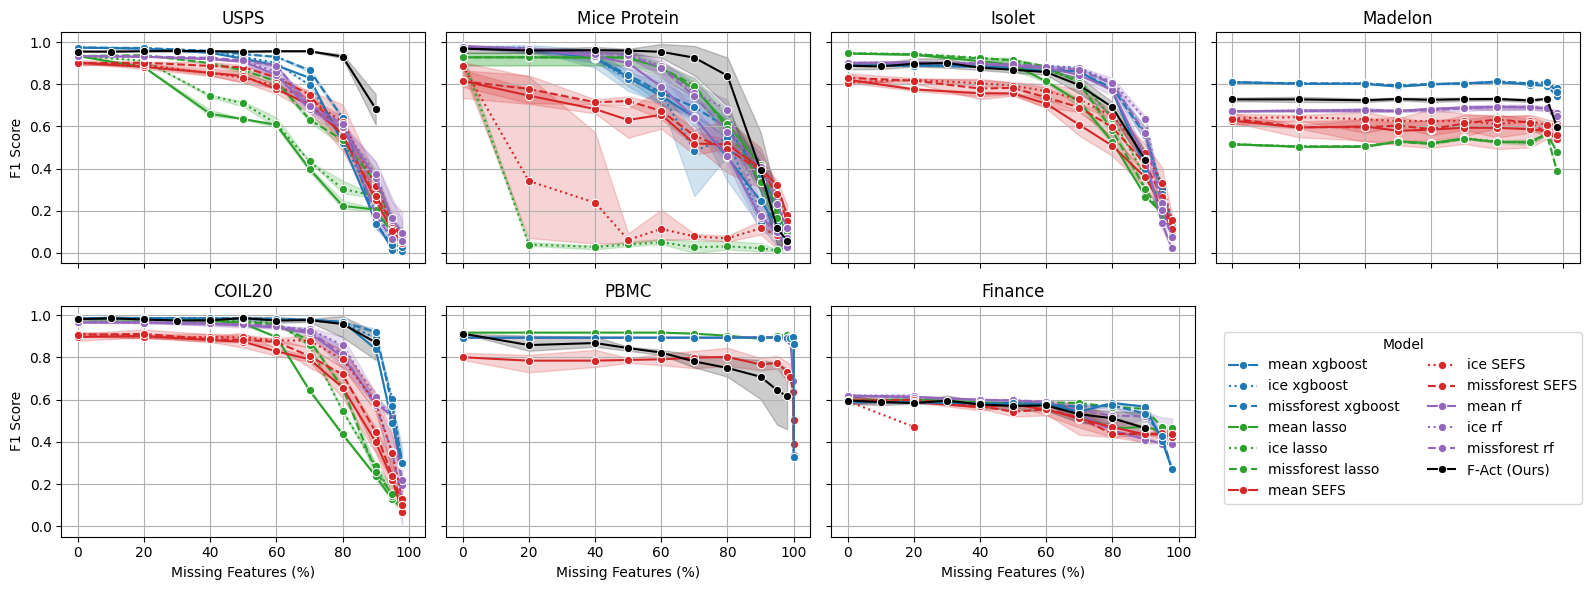

In [21]:
plot_f1_vs_missing_features_all_datasets(df, 'mnar', save=True)

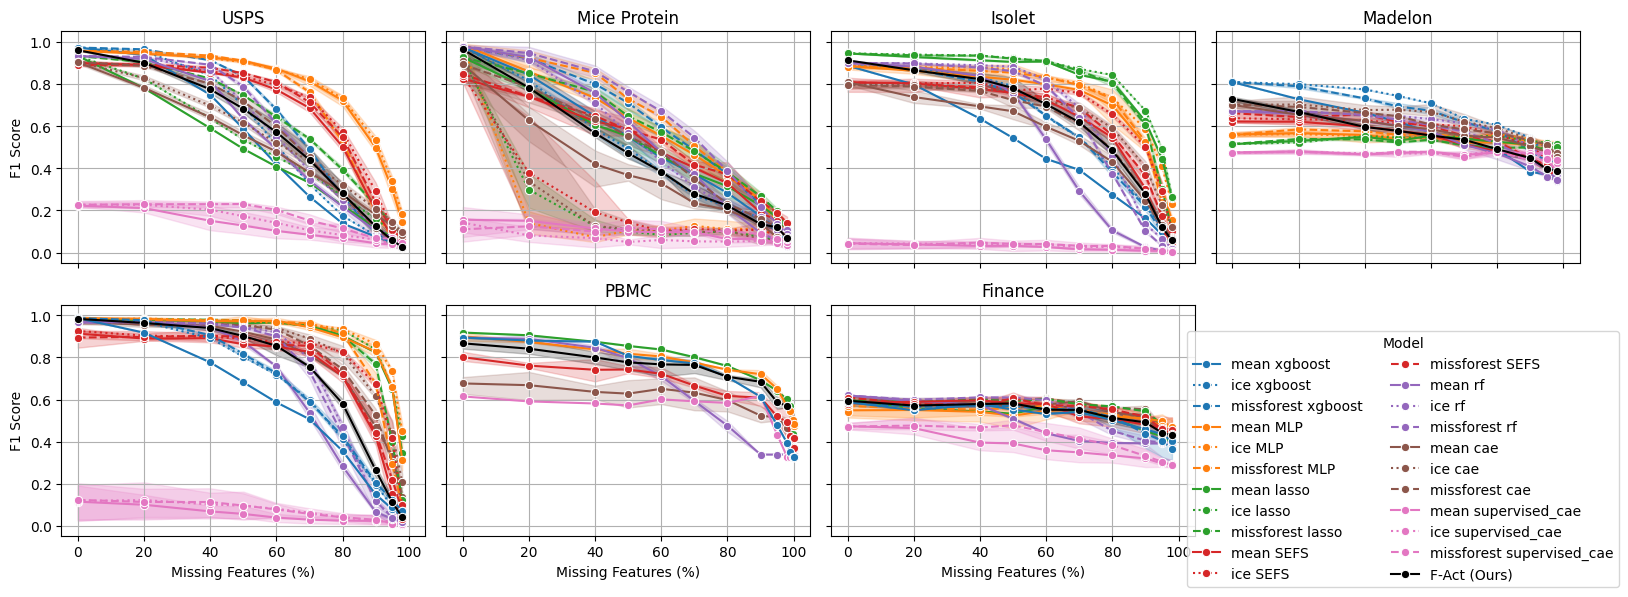

In [22]:
plot_f1_vs_missing_features_all_datasets(df, 'mcar', save=True)